In [636]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

In [637]:
# Load the trained model
model = tf.keras.models.load_model(
    'LSTM_model_64_2.keras'
)

In [638]:
# Load the data
csv_file2 = '/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/FALL/RND2/1_break_1/Data/cleaned_faifa_v2.csv'
df = pd.read_csv(csv_file2)

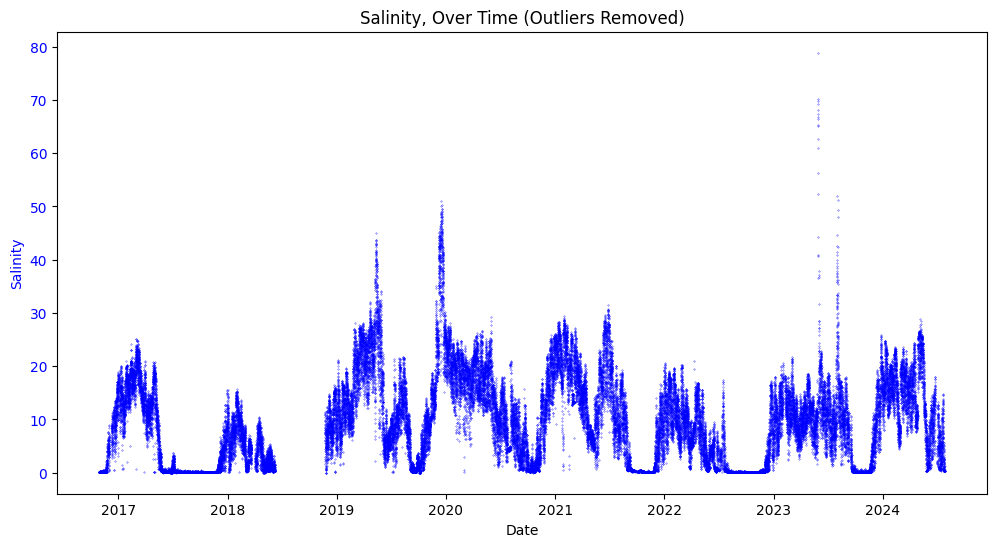

In [639]:

# Convert date_time to datetime format and set as the index
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df['date_time_copy'] = df['date_time']
df.set_index('date_time', inplace=True)

# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity data
ax1.plot(df.index, df['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Title and show plot
plt.title('Salinity, Over Time (Outliers Removed)')
plt.show()

In [640]:
date_time_copy = df.pop('date_time_copy')
timestamp_s = date_time_copy.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [641]:
df = df.loc[:, ['Salinity', 'Day sin', 'Day cos', 'Year sin', 'Year cos']]

In [642]:
df.max()

Salinity    78.865
Day sin      1.000
Day cos      1.000
Year sin     1.000
Year cos     1.000
dtype: float64

In [643]:
df_copy = df.copy()
# Load the preprocessing parameters
preprocessing_params = joblib.load('lstm64_preprocessing_params.pkl')

# Extract the saved scaler, train_mean, and train_std
scaler1 = preprocessing_params['RobustScaler']
scaler2 = preprocessing_params['QuantileTransformer']

# Suppose you have some new data to preprocess (e.g., new_df)
# 1. Apply log1p transformation (if you did it before)
df_copy.loc[:,'Salinity'] = np.log1p(df_copy['Salinity'])

# 2. Transform the data using the saved scaler
df_copy.loc[:,'Salinity'] = scaler1.transform(df_copy[['Salinity']])
df_copy.loc[:,'Salinity'] = scaler2.transform(df_copy[['Salinity']])

# Now new_df_normalized is preprocessed consistently with your original training data.

/var/folders/g5/m8q22yr95qb29lq55z_6_d7r0000gn/T/ipykernel_73512/3283315943.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[[-1.60878465]
 [-1.61402286]
 [-1.61087528]
 ...
 [-1.5313523 ]
 [-1.40133698]
 [-1.11898581]]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.loc[:,'Salinity'] = scaler1.transform(df_copy[['Salinity']])


In [644]:
true_values = df['Salinity']

In [645]:
print(model.input_shape)

(None, 24, 5)


In [646]:
print(df_copy.shape)

(60460, 5)


In [647]:
sequence_length = 24
num_features = 5

In [648]:
test_dataset = df_copy.values.reshape(-1, sequence_length, num_features)
print("Reshaped data shape:", test_dataset.shape)

ValueError: cannot reshape array of size 302300 into shape (24,5)

In [ ]:
# Make predictions
predictions = model.predict(test_dataset)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Import the MeanAbsoluteError class
mae_metric = tf.keras.losses.MeanAbsoluteError()

# Calculate MAE
mae = mae_metric(test_dataset, predictions).numpy()
print(f"Mean Absolute Error (normalize): {mae:.4f}")

Mean Absolute Error (normalize): 0.5509


In [ ]:
print(predictions.shape)

(2519, 24, 1)


In [ ]:
# Force reshape to (n_samples, 1)
predictions = predictions.reshape(-1, 1)

In [ ]:
# # Step 1: Denormalize the data QuantileTransformer
predictions = scaler2.inverse_transform(predictions)

# Step 2: Reverse RobustScaler
predictions = scaler1.inverse_transform(predictions)

# Step 3: Reverse log1p
predictions = np.expm1(predictions)


In [ ]:
df.max()

Salinity    78.865
Day sin      1.000
Day cos      1.000
Year sin     1.000
Year cos     1.000
dtype: float64

In [ ]:
print("Predictions range:", predictions.min(), predictions.max())
print("True values range:", df['Salinity'].min(), df['Salinity'].max())

Predictions range: 9.17957 45.762676
True values range: 0.0016666666666666 78.86500000000001


In [ ]:
# Calculate MAE (denormalize)
mae = mae_metric(df['Salinity'].values, predictions).numpy()
print(f"Mean Absolute Error (normalize): {mae:.4f}")

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [60460,1] vs. [60456,1] [Op:Sub] name: 

ValueError: x and y must be the same size

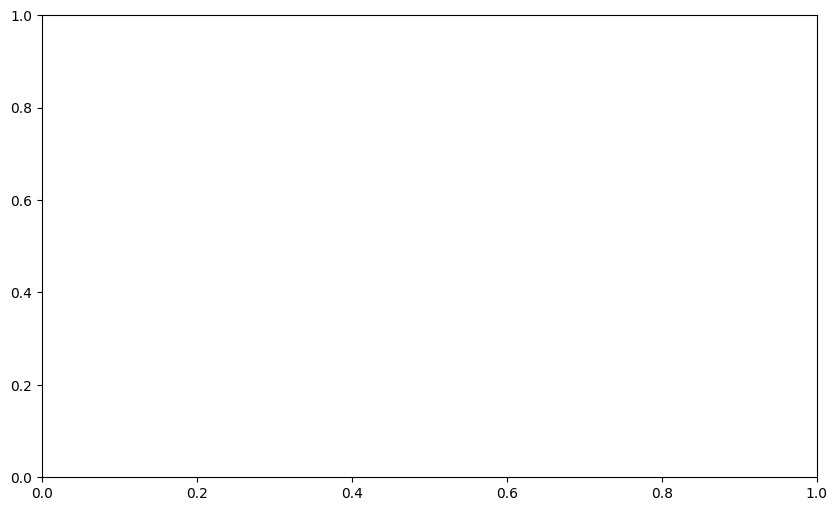

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Salinity'], predictions, alpha=0.6, color='blue', label='Data Points')
plt.plot([df['Salinity'].min(), df['Salinity'].max()],
         [df['Salinity'].min(), df['Salinity'].max()], 'r--', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('True Salinity Values (Denormalized)')
plt.ylabel('Predicted Salinity Values (Denormalized)')
plt.title('Predicted vs. True Salinity Values (Denormalized)(South Bangkok Power Plant Station)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Min of denormalized predictions:", predictions.min())
print("Max of denormalized predictions:", predictions.max())
print("Min of true values:", df['Salinity'].min())
print("Max of true values:", df['Salinity'].max())

Min of denormalized predictions: 0.11542099
Max of denormalized predictions: 42.56778
Min of true values: 0.0016666666666666
Max of true values: 52.31


In [ ]:
print("Shape of denormalized_predictions:", predictions.shape)
print("Shape of denormalized_df['Salinity']:", df['Salinity'].shape)

Shape of denormalized_predictions: (60447, 1)
Shape of denormalized_df['Salinity']: (60447,)


In [ ]:
predictions = predictions.reshape(-1)  # Now predictions is (46154,)

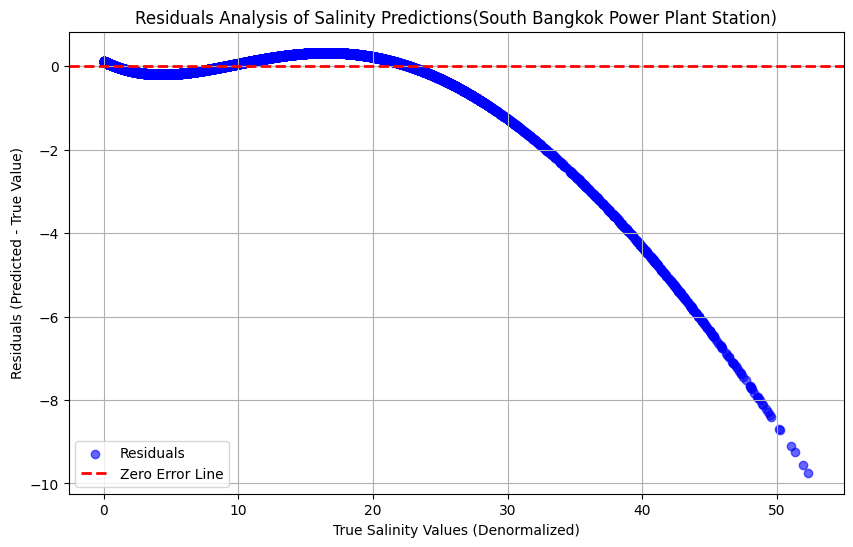

In [ ]:
# Calculate residuals (errors)
residuals = predictions - true_values

plt.figure(figsize=(10, 6))
plt.scatter(true_values, residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.xlabel('True Salinity Values (Denormalized)')
plt.ylabel('Residuals (Predicted - True Value)')
plt.title('Residuals Analysis of Salinity Predictions(South Bangkok Power Plant Station)')
plt.legend()
plt.grid(True)
plt.show()

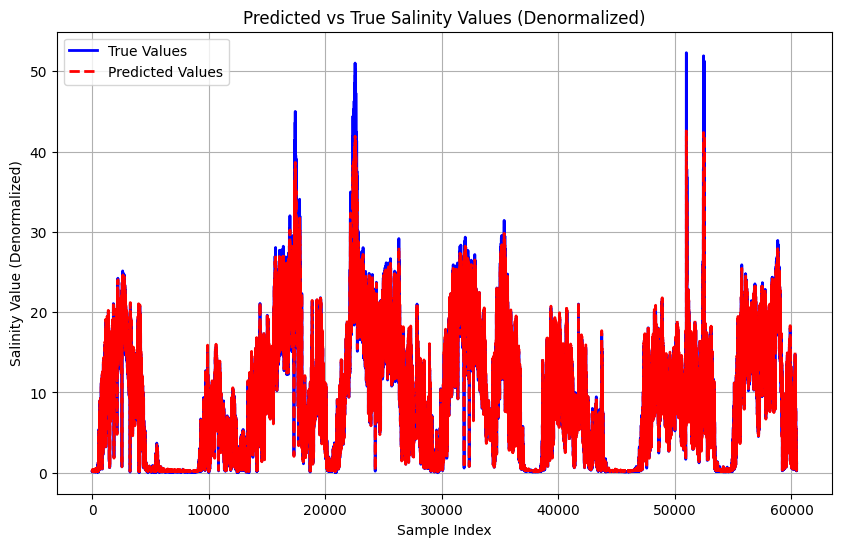

In [ ]:
# Plot Predicted vs True Salinity Values
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', color='blue', linewidth=2)
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Salinity Value (Denormalized)')
plt.title('Predicted vs True Salinity Values (Denormalized)')
plt.legend()
plt.grid(True)
plt.show()